In [1]:
!python -V

Python 3.12.1


In [2]:
!pip install mlflow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [5]:
import mlflow

# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow.set_experiment('nyc-taxi-experiments')

# with mlflow.start_run():
#     mlflow.log_param("test_param", 123)
#     mlflow.log_metric("test_metric", 0.456)
mlflow.set_tracking_uri("sqlite:////workspaces/mlops/mlflow.db")
mlflow.set_experiment('nyc-taxi-experiments')


2025/07/20 05:44:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/20 05:44:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops/03-tracking/experiment_tracking/mlruns/1', creation_time=1752983372847, experiment_id='1', last_update_time=1752983372847, lifecycle_stage='active', name='nyc-taxi-experiments', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [7]:
df = df[df.trip_type==2.0]

In [8]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
5,2,2021-02-01 00:33:03,2021-02-01 00:40:54,N,5.0,197,219,1.0,3.30,15.0,0.0,0.0,0.76,0.00,None,0.3,16.06,1.0,2.0,0.0
9,2,2021-02-01 02:56:55,2021-02-01 02:58:38,N,5.0,78,78,1.0,0.00,24.0,0.0,0.0,0.00,0.00,None,0.3,24.30,2.0,2.0,0.0
17,2,2021-02-01 03:59:27,2021-02-01 03:59:34,N,5.0,136,136,1.0,0.19,10.0,0.0,0.0,0.30,0.00,None,0.3,10.60,1.0,2.0,0.0
18,2,2021-02-01 04:09:11,2021-02-01 04:09:15,N,5.0,116,116,2.0,0.00,7.0,0.0,0.0,0.00,0.00,None,0.3,7.30,2.0,2.0,0.0
54,2,2021-02-01 09:26:36,2021-02-01 09:26:36,N,5.0,94,74,1.0,0.00,22.0,0.0,0.0,3.00,0.00,None,0.3,25.30,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35391,2,2021-02-28 20:15:35,2021-02-28 20:32:59,N,5.0,243,235,2.0,2.32,16.0,0.0,0.0,0.00,0.00,None,0.3,16.30,2.0,2.0,0.0
35423,2,2021-02-28 21:54:17,2021-02-28 22:04:58,N,5.0,247,69,2.0,1.51,18.0,0.0,0.0,0.00,0.00,None,0.3,18.30,2.0,2.0,0.0
35446,2,2021-02-28 22:07:07,2021-02-28 22:25:11,N,5.0,69,78,2.0,3.57,12.0,0.0,0.0,0.00,0.00,None,0.3,12.30,2.0,2.0,0.0
35447,2,2021-02-28 22:41:32,2021-02-28 23:08:58,N,5.0,69,74,2.0,5.06,17.0,0.0,0.0,0.00,0.00,None,0.3,17.30,2.0,2.0,0.0


In [9]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]


In [10]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
5,2,2021-02-01 00:33:03,2021-02-01 00:40:54,N,5.0,197,219,1.0,3.30,15.0,...,0.0,0.76,0.00,None,0.3,16.06,1.0,2.0,0.00,7.850000
9,2,2021-02-01 02:56:55,2021-02-01 02:58:38,N,5.0,78,78,1.0,0.00,24.0,...,0.0,0.00,0.00,None,0.3,24.30,2.0,2.0,0.00,1.716667
114,2,2021-02-01 19:01:09,2021-02-01 19:11:20,N,5.0,75,74,1.0,1.80,15.0,...,0.0,0.00,0.00,None,0.3,15.30,1.0,2.0,0.00,10.183333
125,2,2021-02-01 22:57:12,2021-02-01 23:07:36,N,5.0,223,92,1.0,4.98,50.0,...,0.0,0.00,0.00,None,0.3,50.30,2.0,2.0,0.00,10.400000
150,2,2021-02-02 06:31:38,2021-02-02 06:50:10,N,5.0,223,100,1.0,5.64,50.0,...,0.0,13.26,0.00,None,0.3,66.31,1.0,2.0,2.75,18.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35391,2,2021-02-28 20:15:35,2021-02-28 20:32:59,N,5.0,243,235,2.0,2.32,16.0,...,0.0,0.00,0.00,None,0.3,16.30,2.0,2.0,0.00,17.400000
35423,2,2021-02-28 21:54:17,2021-02-28 22:04:58,N,5.0,247,69,2.0,1.51,18.0,...,0.0,0.00,0.00,None,0.3,18.30,2.0,2.0,0.00,10.683333
35446,2,2021-02-28 22:07:07,2021-02-28 22:25:11,N,5.0,69,78,2.0,3.57,12.0,...,0.0,0.00,0.00,None,0.3,12.30,2.0,2.0,0.00,18.066667
35447,2,2021-02-28 22:41:32,2021-02-28 23:08:58,N,5.0,69,74,2.0,5.06,17.0,...,0.0,0.00,0.00,None,0.3,17.30,2.0,2.0,0.00,27.433333


/tmp/ipykernel_55158/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

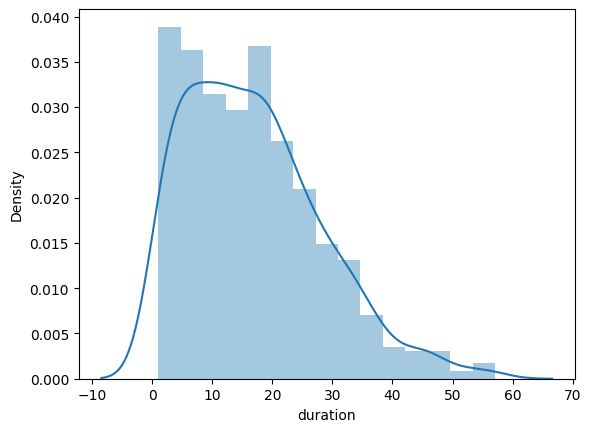

In [11]:
sns.distplot(df.duration)

In [12]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    612.000000
mean      16.866449
std       11.411988
min        1.000000
50%       15.375000
95%       37.394167
98%       45.850667
99%       49.217833
max       57.116667
Name: duration, dtype: float64

In [13]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df.loc[:, categorical] = df.loc[:, categorical].astype(str)

/tmp/ipykernel_55158/4207740009.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['197' '78' '75' '223' '223' '116' '74' '129' '152' '47' '168' '75' '95'
 '265' '265' '69' '168' '28' '121' '130' '119' '215' '167' '75' '167'
 '241' '247' '42' '169' '41' '167' '42' '42' '60' '75' '74' '169' '243'
 '147' '95' '250' '98' '74' '124' '75' '250' '42' '51' '247' '254' '152'
 '41' '82' '78' '60' '130' '130' '69' '130' '69' '247' '41' '74' '134'
 '93' '74' '41' '41' '247' '16' '248' '17' '42' '69' '247' '82' '247'
 '250' '69' '41' '41' '69' '41' '41' '74' '119' '247' '74' '41' '243'
 '244' '74' '116' '130' '74' '130' '74' '74' '174' '254' '74' '235' '81'
 '59' '69' '247' '74' '42' '82' '95' '247' '116' '74' '20' '78' '220'
 '247' '69' '41' '247' '174' '42' '42' '47' '254' '82' '130' '25' '242'
 '134' '42' '121' '121' '196' '69' '32' '82' '69' '69' '213' '78' '69'
 '134' '169' '127' '235' '82' '121' '213' '135' '95' '244' 

In [14]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [15]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

5.746304968778015

/tmp/ipykernel_55158/3843849186.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred,label='prediction')
/tmp/ipykernel_55158/3843849186.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,label='actual')


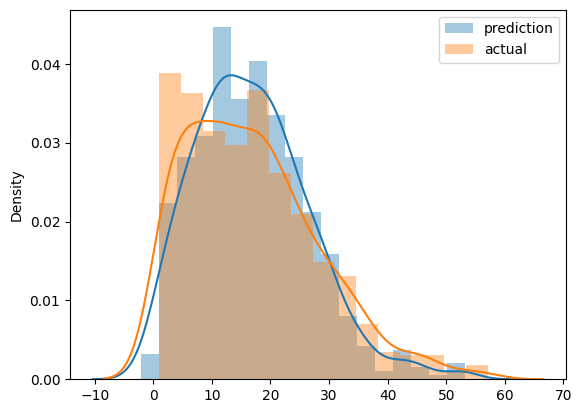

In [16]:
sns.distplot(y_pred,label='prediction')
sns.distplot(y_train,label='actual')

plt.legend()

In [17]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [ ]:
lr = Lasso(0.0001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
 
root_mean_squared_error(y_val, y_pred)

7.616617761096093

In [25]:
import pickle

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
with mlflow.start_run():
    mlflow.set_tag("developer", "ayush")
    mlflow.set_tag("model", "linear regression")
    
    mlflow.log_param("train_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    mlflow.log_metric("rmse", root_mean_squared_error(y_val, y_pred))
    
    mlflow.sklearn.log_model(lr, artifact_path="model", registered_model_name="DurationPredictionModel")

    mlflow.log_artifact("models/lin_reg.bin", artifact_path="model")

2025/07/20 05:45:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/20 05:46:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/20 05:46:00 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/20 05:46:00 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'DurationPredictionModel' already exists. Creating a new version of this model...
Created version '6' of model 'DurationPredictionModel'.


In [29]:
with mlflow.start_run():
    mlflow.set_tag("developer", "your_name")
    mlflow.set_tag("model", "linear_regression")
    
    mlflow.log_param("train_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    mlflow.log_metric("rmse", root_mean_squared_error(y_val, y_pred))
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [28]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [29]:
!pip install hyperopt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [30]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse_value = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse_value)

        return {'loss': rmse_value, 'status': STATUS_OK}

In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:10:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.51723                           
[1]	validation-rmse:8.09730                           
[2]	validation-rmse:7.39259                           
[3]	validation-rmse:7.04760                           
[4]	validation-rmse:6.87911                           
[5]	validation-rmse:6.78544                           
[6]	validation-rmse:6.73393                           
[7]	validation-rmse:6.70459                           
[8]	validation-rmse:6.68203                           
[9]	validation-rmse:6.66558                           
  2%|▏         | 1/50 [00:06<05:30,  6.75s/trial, best loss: 6.665578243875738]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:10:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.88936                                                    
[1]	validation-rmse:8.50228                                                    
[2]	validation-rmse:7.70947                                                    
[3]	validation-rmse:7.26767                                                    
[4]	validation-rmse:7.02178                                                    
[5]	validation-rmse:6.88482                                                    
[6]	validation-rmse:6.79633                                                    
[7]	validation-rmse:6.74477                                                    
[8]	validation-rmse:6.70941                                                    
[9]	validation-rmse:6.68658                                                    
  4%|▍         | 2/50 [00:15<06:34,  8.22s/trial, best loss: 6.665578243875738]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:10:52] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.81836                                                    
[1]	validation-rmse:6.82327                                                    
[2]	validation-rmse:6.59211                                                    
[3]	validation-rmse:6.52740                                                    
[4]	validation-rmse:6.49712                                                    
[5]	validation-rmse:6.48851                                                    
[6]	validation-rmse:6.48218                                                    
[7]	validation-rmse:6.47627                                                    
[8]	validation-rmse:6.46702                                                    
[9]	validation-rmse:6.46031                                                    
  6%|▌         | 3/50 [00:26<07:10,  9.15s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.18270                                                   
[1]	validation-rmse:8.86374                                                    
[2]	validation-rmse:8.03345                                                    
[3]	validation-rmse:7.52286                                                    
[4]	validation-rmse:7.21150                                                    
[5]	validation-rmse:7.02326                                                    
[6]	validation-rmse:6.90730                                                    
[7]	validation-rmse:6.82907                                                    
[8]	validation-rmse:6.78035                                                    
[9]	validation-rmse:6.74379                                                    
  8%|▊         | 4/50 [00:32<06:10,  8.06s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.02864                                                   
[1]	validation-rmse:10.07851                                                   
[2]	validation-rmse:9.32324                                                    
[3]	validation-rmse:8.72907                                                    
[4]	validation-rmse:8.26631                                                    
[5]	validation-rmse:7.90743                                                    
[6]	validation-rmse:7.63060                                                    
[7]	validation-rmse:7.41832                                                    
[8]	validation-rmse:7.25522                                                    
[9]	validation-rmse:7.13086                                                    
[0]	validation-rmse:11.25705                                                   
[1]	validation-rmse:10.45751                                                   
 10%|█         | 5/50 [00:39<05:46,  7.6

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:16] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:9.79052                                                    
[3]	validation-rmse:9.24004                                                    
[4]	validation-rmse:8.78757                                                    
[5]	validation-rmse:8.41892                                                    
[6]	validation-rmse:8.11812                                                    
[7]	validation-rmse:7.87291                                                    
[8]	validation-rmse:7.67614                                                    
[9]	validation-rmse:7.51845                                                    
 12%|█▏        | 6/50 [00:40<03:58,  5.42s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:17] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.71937                                                   
[1]	validation-rmse:11.26425                                                   
[2]	validation-rmse:10.84502                                                   
[3]	validation-rmse:10.45964                                                   
[4]	validation-rmse:10.10608                                                   
[5]	validation-rmse:9.78194                                                    
[6]	validation-rmse:9.48547                                                    
[7]	validation-rmse:9.21453                                                    
[8]	validation-rmse:8.96698                                                    
[9]	validation-rmse:8.74156                                                    
 14%|█▍        | 7/50 [00:56<06:24,  8.94s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:33] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.35328                                                   
[1]	validation-rmse:9.07946                                                    
[2]	validation-rmse:8.22335                                                    
[3]	validation-rmse:7.66871                                                    
[4]	validation-rmse:7.30650                                                    
[5]	validation-rmse:7.07258                                                    
[6]	validation-rmse:6.92171                                                    
[7]	validation-rmse:6.82514                                                    
[8]	validation-rmse:6.75816                                                    
[9]	validation-rmse:6.71203                                                    
 16%|█▌        | 8/50 [01:01<05:12,  7.44s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:37] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.57967                                                   
[1]	validation-rmse:9.39043                                                    
[2]	validation-rmse:8.54039                                                    
[3]	validation-rmse:7.94402                                                    
[4]	validation-rmse:7.53179                                                    
[5]	validation-rmse:7.24673                                                    
[6]	validation-rmse:7.04990                                                    
[7]	validation-rmse:6.91425                                                    
[8]	validation-rmse:6.81842                                                    
[9]	validation-rmse:6.75253                                                    
 18%|█▊        | 9/50 [01:16<06:50, 10.02s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:11:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.77853                                                    
[1]	validation-rmse:8.36992                                                    
[2]	validation-rmse:7.59323                                                    
[3]	validation-rmse:7.17593                                                    
[4]	validation-rmse:6.94794                                                    
[5]	validation-rmse:6.82018                                                    
[6]	validation-rmse:6.74261                                                    
[7]	validation-rmse:6.69971                                                    
[8]	validation-rmse:6.67020                                                    
[9]	validation-rmse:6.65002                                                    
 20%|██        | 10/50 [01:24<06:09,  9.24s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.67989                                                     
[1]	validation-rmse:6.64400                                                     
[2]	validation-rmse:6.62744                                                     
[3]	validation-rmse:6.61812                                                     
[4]	validation-rmse:6.61306                                                     
[5]	validation-rmse:6.60448                                                     
[6]	validation-rmse:6.59839                                                     
[7]	validation-rmse:6.59121                                                     
[8]	validation-rmse:6.57981                                                     
[9]	validation-rmse:6.57115                                                     
[0]	validation-rmse:10.98573                                                    
[1]	validation-rmse:10.01411                                                    
 22%|██▏       | 11/50 [01:2

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:9.25525                                                     
[3]	validation-rmse:8.66708                                                     
[4]	validation-rmse:8.21630                                                     
[5]	validation-rmse:7.87382                                                     
[6]	validation-rmse:7.61497                                                     
[7]	validation-rmse:7.41697                                                     
[8]	validation-rmse:7.26945                                                     
[9]	validation-rmse:7.15790                                                     
 24%|██▍       | 12/50 [01:27<03:22,  5.32s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:04] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.70302                                                    
[1]	validation-rmse:9.57784                                                     
[2]	validation-rmse:8.74246                                                     
[3]	validation-rmse:8.13937                                                     
[4]	validation-rmse:7.69581                                                     
[5]	validation-rmse:7.38650                                                     
[6]	validation-rmse:7.15954                                                     
[7]	validation-rmse:6.99269                                                     
[8]	validation-rmse:6.87816                                                     
[9]	validation-rmse:6.79400                                                     
 26%|██▌       | 13/50 [02:05<09:14, 14.99s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:41] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.76666                                                    
[1]	validation-rmse:11.35268                                                    
[2]	validation-rmse:10.96942                                                    
[3]	validation-rmse:10.61505                                                    
[4]	validation-rmse:10.28776                                                    
[5]	validation-rmse:9.98592                                                     
[6]	validation-rmse:9.70771                                                     
[7]	validation-rmse:9.45173                                                     
[8]	validation-rmse:9.21655                                                     
[9]	validation-rmse:9.00079                                                     
 28%|██▊       | 14/50 [02:09<07:05, 11.81s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.47330                                                     
[1]	validation-rmse:8.04971                                                     
[2]	validation-rmse:7.35212                                                     
[3]	validation-rmse:7.01602                                                     
[4]	validation-rmse:6.85416                                                     
[5]	validation-rmse:6.76273                                                     
[6]	validation-rmse:6.70855                                                     
[7]	validation-rmse:6.67637                                                     
[8]	validation-rmse:6.65675                                                     
[9]	validation-rmse:6.64294                                                     
 30%|███       | 15/50 [02:14<05:45,  9.87s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:51] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.30768                                                    
[1]	validation-rmse:9.02431                                                     
[2]	validation-rmse:8.18056                                                     
[3]	validation-rmse:7.64121                                                     
[4]	validation-rmse:7.29534                                                     
[5]	validation-rmse:7.08043                                                     
[6]	validation-rmse:6.93987                                                     
[7]	validation-rmse:6.85135                                                     
[8]	validation-rmse:6.78984                                                     
[9]	validation-rmse:6.74911                                                     
 32%|███▏      | 16/50 [02:19<04:41,  8.28s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:12:55] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.55524                                                    
[1]	validation-rmse:9.34531                                                     
[2]	validation-rmse:8.47875                                                     
[3]	validation-rmse:7.86475                                                     
[4]	validation-rmse:7.43722                                                     
[5]	validation-rmse:7.14591                                                     
[6]	validation-rmse:6.94433                                                     
[7]	validation-rmse:6.80488                                                     
[8]	validation-rmse:6.70339                                                     
[9]	validation-rmse:6.63329                                                     
[0]	validation-rmse:10.97680                                                    
[1]	validation-rmse:9.99935                                                     
 34%|███▍      | 17/50 [02:4

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:13:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:9.23696                                                     
[3]	validation-rmse:8.64812                                                     
[4]	validation-rmse:8.19862                                                     
[5]	validation-rmse:7.85703                                                     
[6]	validation-rmse:7.59915                                                     
[7]	validation-rmse:7.40423                                                     
[8]	validation-rmse:7.25885                                                     
[9]	validation-rmse:7.14780                                                     
 36%|███▌      | 18/50 [02:50<05:40, 10.65s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:13:26] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.92612                                                     
[1]	validation-rmse:6.71924                                                     
[2]	validation-rmse:6.69939                                                     
[3]	validation-rmse:6.68708                                                     
[4]	validation-rmse:6.67714                                                     
[5]	validation-rmse:6.67670                                                     
[6]	validation-rmse:6.67565                                                     
[7]	validation-rmse:6.67166                                                     
[8]	validation-rmse:6.65977                                                     
[9]	validation-rmse:6.65522                                                     
 38%|███▊      | 19/50 [02:52<04:09,  8.05s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:13:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.01212                                                    
[1]	validation-rmse:8.61593                                                     
[2]	validation-rmse:7.75601                                                     
[3]	validation-rmse:7.24379                                                     
[4]	validation-rmse:6.93790                                                     
[5]	validation-rmse:6.75727                                                     
[6]	validation-rmse:6.64756                                                     
[7]	validation-rmse:6.57598                                                     
[8]	validation-rmse:6.52894                                                     
[9]	validation-rmse:6.49664                                                     
 40%|████      | 20/50 [03:20<06:59, 13.99s/trial, best loss: 6.460306620093477]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [05:13:56] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



: 

In [ ]:
params = {
    'learning_rate': 0.6240816486229196,
    'max_depth': 55,
    'min_child_weight': 1.192214620481515,
    'reg_alpha': 0.016597419370730778,
    'reg_lambda': 0.0072444028346028855,
    'seed': 42,
    'objective': 'reg:linear'
}

: 

In [ ]:
# import mlflow.xgboost


mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, "validation")],
            early_stopping_rounds=20)

2025/07/20 05:33:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '71b909e5f9d64dfeaa54c4df265669e4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


In [ ]:
import mlflow.sklearn
import xgboost as xgb
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


# mlflow.sklearn.autolog()

with mlflow.start_run():
    # mlflow.xgboost.autolog(disable=True)
    # mlflow.xgboost.autolog()

    params = {
    'learning_rate': 0.6240816486229196,
    'max_depth': 55,
    'min_child_weight': 1.192214620481515,
    'reg_alpha': 0.016597419370730778,
    'reg_lambda': 0.0072444028346028855,
    'seed': 42,
    'objective': 'reg:linear'
   }
    
    mlflow.log_params(params)

    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, "validation")],
            early_stopping_rounds=20)

    with open('models/preprocessor.b','wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact('models/preprocessor.b', artifact_path="preprocessor")

    mlflow.xgboost.log_model(
        xgb_model=booster,
        artifact_path="model_mlflow",
    )

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [06:13:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:7.81836
[1]	validation-rmse:6.82327
[2]	validation-rmse:6.59211
[3]	validation-rmse:6.52740
[4]	validation-rmse:6.49712
[5]	validation-rmse:6.48851
[6]	validation-rmse:6.48218
[7]	validation-rmse:6.47627
[8]	validation-rmse:6.46702
[9]	validation-rmse:6.46031


2025/07/20 06:13:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/python/3.12.1/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [06:13:12] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/20 06:13:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
